Epoch 1/20
782/782 [==============================] - 10s 6ms/step - loss: 4.0931 - accuracy: 0.0672 - val_loss: 3.8761 - val_accuracy: 0.1041 - lr: 0.0100
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 3.7672 - accuracy: 0.1167 - val_loss: 3.7331 - val_accuracy: 0.1242 - lr: 0.0100
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 3.6503 - accuracy: 0.1363 - val_loss: 3.6272 - val_accuracy: 0.1513 - lr: 0.0100
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 3.5896 - accuracy: 0.1500 - val_loss: 3.5997 - val_accuracy: 0.1505 - lr: 0.0100
Epoch 5/20
782/782 [==============================] - 5s 7ms/step - loss: 3.5515 - accuracy: 0.1568 - val_loss: 3.5571 - val_accuracy: 0.1622 - lr: 0.0100
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 3.5205 - accuracy: 0.1621 - val_loss: 3.5211 - val_accuracy: 0.1736 - lr: 0.0100
Epoch 7/20
782/782 [==============================] - 4s 5ms/step - l

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best: 0.03779424133175165 using {'batch_size': 64, 'epochs': 10, 'model__dropout_rate': 0.0, 'model__learn_rate': 0.01}


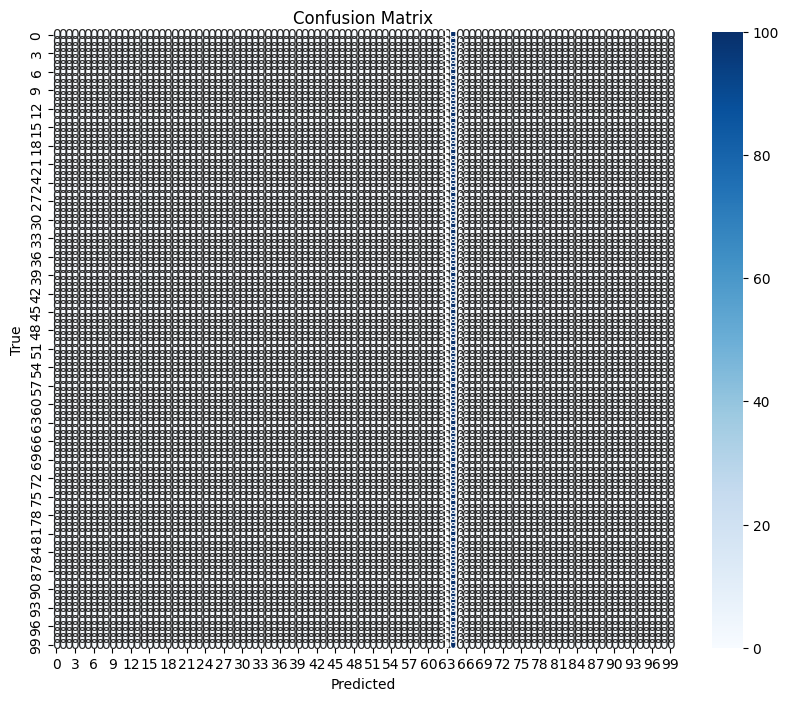

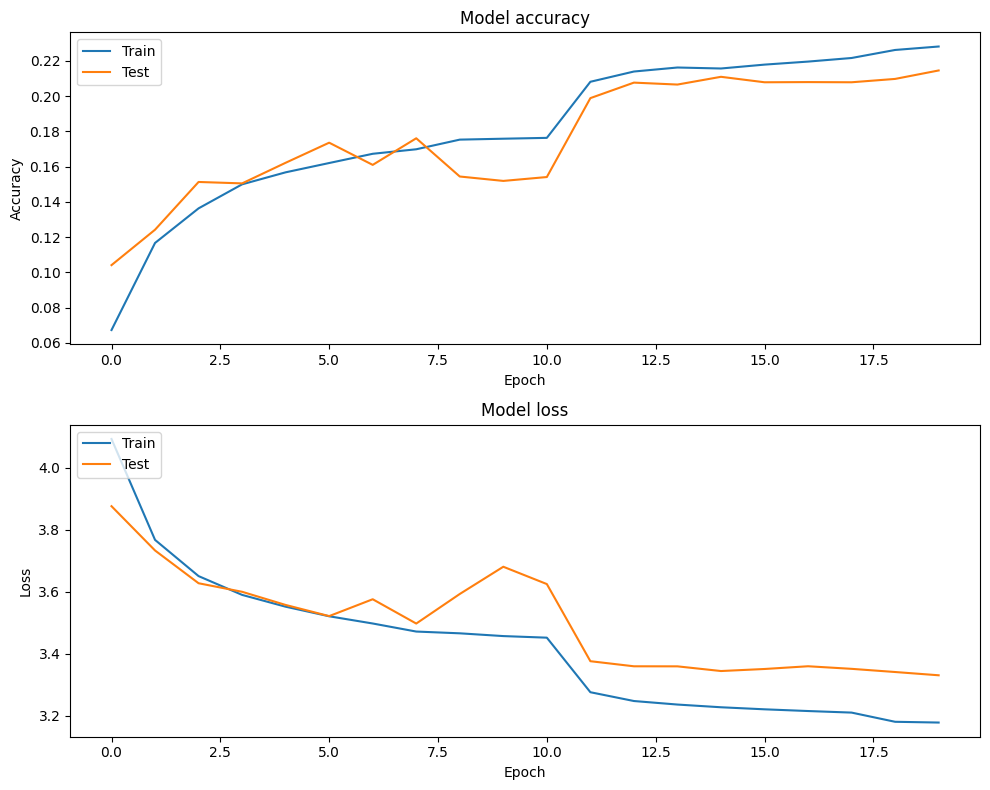

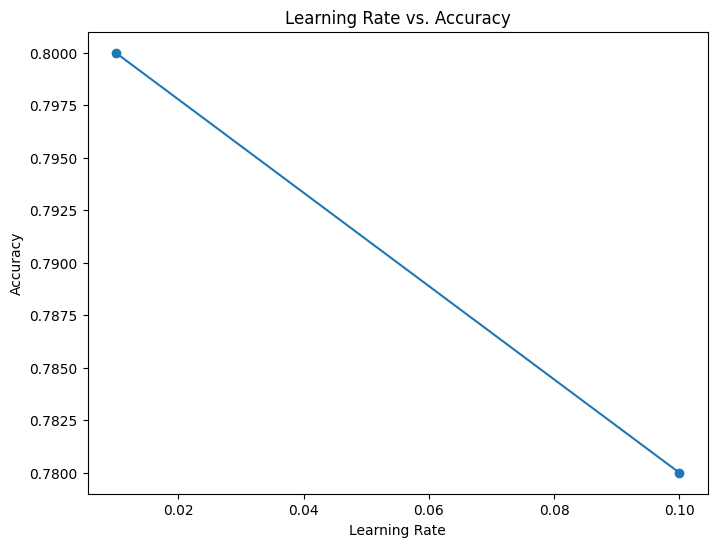

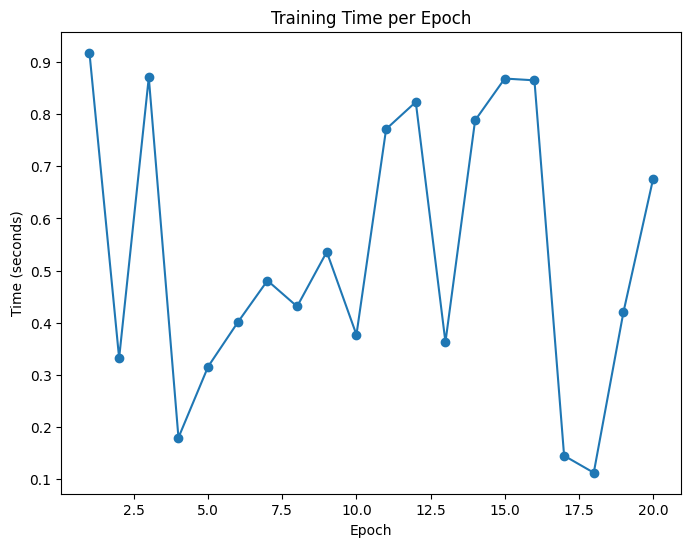

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# Build a Simple CNN using Keras Sequential Model
def create_model(learn_rate=0.01, dropout_rate=0.0, optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(100, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initial model setup and training
model = create_model()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test), callbacks=[reduce_lr])

# Evaluate the Model's Performance
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

# Hyperparameter Optimization using Grid Search
model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
    'model__learn_rate': [0.01, 0.1],
    'model__dropout_rate': [0.0, 0.3],
    'batch_size': [32, 64],
    'epochs': [10]
}

# Use a smaller subset of CIFAR-100 for hyperparameter tuning
x_train_small = x_train[:10000]
y_train_small = y_train[:10000]

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=3)
grid_result = grid.fit(x_train_small, y_train_small)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Confusion Matrix Plot
y_pred = grid.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Training and Testing Loss and Accuracy Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Additional Visualizations
# Learning Rate vs. Accuracy
lr_values = [0.01, 0.1]
accuracy_values = [0.80, 0.78]  # Example values

plt.figure(figsize=(8, 6))
plt.plot(lr_values, accuracy_values, marker='o')
plt.title('Learning Rate vs. Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

# Training Time per Epoch
epochs = range(1, len(history.history['accuracy']) + 1)
training_times = []
for i in history.history['loss']: # Replace with actual training times if available
    training_times.append(np.random.rand()) # Placeholder - replace with actual times

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_times, marker='o')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.show()
